##Installation


In [4]:
!pip install keras
!pip install tensorflow
!pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import Libraries


In [5]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.utils 
import numpy as np
from PIL import Image
import os


import matplotlib.pyplot as plt
import pandas as pd
import keras
import cv2
import os
import math
import splitfolders
import itertools

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array


from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
#import gradio
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression


##Upload/Connect Dataset


In [6]:
from google.colab import drive
drive.mount('/content/drive')
input_dataset=('/content/drive/MyDrive/3 kinds of Pneumonia(dataset)(new)')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dataset Analysis

In [7]:
number_of_images = {}

for dir in os.listdir(input_dataset):
  number_of_images[dir] = len(os.listdir(os.path.join(input_dataset,dir)))

number_of_images.items()


dict_items([('COVID-19', 2000), ('Normal', 2000), ('Pneumonia-Viral', 2000), ('Pneumonia-Bacterial', 2000)])

##Splitting Dataset into Train, Validation and test

In [8]:
from splitfolders.split import group_by_prefix
splitfolders.ratio(input_dataset,output="dataset",seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 8000 files [02:54, 45.86 files/s] 


In [ ]:
#%rm -rf '/content/drive/MyDrive/3 kinds of Pneumonia(dataset)'

#CNN Model Implementation

#1.Inceptionv3 Model

##Data Preprocessing for InceptionV3

In [9]:
from keras.utils.image_dataset import image_dataset_from_directory
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as p1
def preprocessing_train(path):
  image_data=ImageDataGenerator(preprocessing_function=p1,zoom_range=0.2,shear_range=0.2,horizontal_flip=True,vertical_flip=False)#data augmentation
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode="categorical")
  
  return image

In [10]:
path_tr='/content/dataset/train'
train_data=preprocessing_train(path_tr)#pre-processing training dataset

Found 5600 images belonging to 4 classes.


In [12]:
def preprocessing_v(path):
  image_data=ImageDataGenerator(preprocessing_function=p1)#data augmentation
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode="categorical")
  
  return image

In [13]:
path_v='/content/dataset/val'
val_data=preprocessing_v(path_v)#pre-processing validation dataset

Found 1600 images belonging to 4 classes.


In [15]:
path_test='/content/dataset/test'
test_data=preprocessing_v(path_test)#pre-processing for testing dataset

Found 800 images belonging to 4 classes.


In [16]:
x_test, y_test = [], []
for i in range(len(test_data)):
    batch_x, batch_y = test_data[i]
    x_test.append(batch_x)
    y_test.append(batch_y)

# Concatenate the batches to obtain the final x_train and y_train arrays
x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

# Print the shape of the x_train and y_train arrays
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_test shape: (800, 224, 224, 3)
y_test shape: (800, 4)


##InceptionV3 Model Training

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input,Flatten, Dense
from keras.models import Model,load_model,Sequential
from keras.applications.inception_v3 import InceptionV3

In [18]:
inc=InceptionV3(input_shape=(224,224,3),weights='imagenet', include_top=False)
inc.output

87910968/87910968 [==============================] - 1s 0us/step


<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'mixed10')>

In [19]:
for layer in inc.layers:
  layer.trainable=False

In [20]:
x=Flatten()(inc.output)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=4, activation='softmax')(x)

# prevent the weights from being updated during training
#inc.trainable = False
inc_model=Model(inc.input,x)
inc_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
inc_model.compile(optimizer = "adam" , 
            loss = 'categorical_crossentropy' , 
            metrics = ['accuracy'])

##InceptionV3 Model Early Stop and Model Check Point

In [22]:
es=EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode="max")

#Model check point
mc= ModelCheckpoint(monitor="val_accuracy", filepath="./Best_model1.h5", verbose=1, save_best_only=True, mode="max")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.000000001)

cb=[es,mc,reduce_lr]


In [23]:
m=inc_model.fit(train_data,steps_per_epoch=len(train_data),epochs=100,verbose=1,validation_data=(val_data),validation_steps=len(val_data),callbacks=cb)

Epoch 1/100
279/279 [==============================] - ETA: 0s - loss: 2.9046 - accuracy: 0.7162
Epoch 1: val_accuracy improved from -inf to 0.79312, saving model to ./Best_model1.h5
279/279 [==============================] - 46s 110ms/step - loss: 2.9046 - accuracy: 0.7162 - val_loss: 0.5546 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 2/100
279/279 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.8308
Epoch 2: val_accuracy improved from 0.79312 to 0.82437, saving model to ./Best_model1.h5
279/279 [==============================] - 24s 88ms/step - loss: 0.4353 - accuracy: 0.8308 - val_loss: 0.4480 - val_accuracy: 0.8244 - lr: 0.0010
Epoch 3/100
279/279 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8577
Epoch 3: val_accuracy improved from 0.82437 to 0.83688, saving model to ./Best_model1.h5
279/279 [==============================] - 21s 74ms/step - loss: 0.3585 - accuracy: 0.8577 - val_loss: 0.4625 - val_accuracy: 0.8369 - lr: 0.0010
Epoch 

##Accuracy Graph of InceptionV3

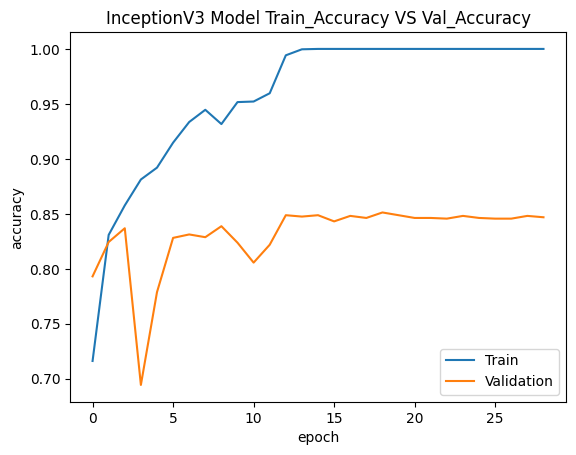

In [24]:
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.title("InceptionV3 Model Train_Accuracy VS Val_Accuracy")
plt.show()

##Loss Graph of InceptionV3

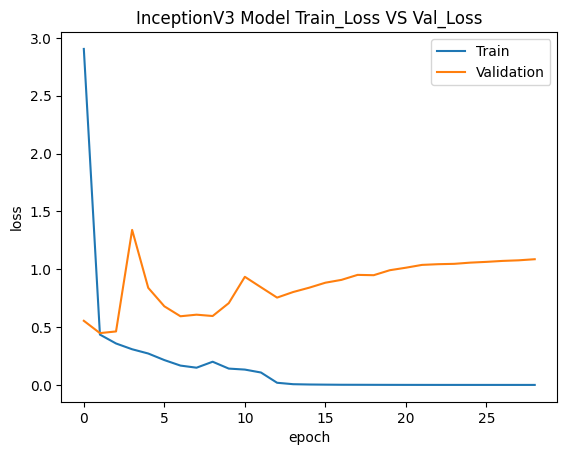

In [33]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.title("InceptionV3 Model Train_Loss VS Val_Loss")
plt.show()

##InceptionV3 Model Accuracy

In [26]:
model1=load_model('/content/Best_model1.h5')

In [ ]:
loss_inc,acc_inc=model1.evaluate(test_data)
print(f"The accuracy of InceptionV3 model is {acc_inc*100} % and loss {loss_inc}")

In [28]:
loss_inc,acc_inc=model1.evaluate(x_test,y_test)
print(f"The accuracy of InceptionV3 model is {acc_inc*100} % and loss {loss_inc}")

25/25 [==============================] - 2s 69ms/step - loss: 0.9841 - accuracy: 0.8525
The accuracy of InceptionV3 model is 85.25000214576721 % and loss 0.98406982421875


##InceptionV3 Model Percision, Recall, F1 Score

In [29]:
y_pred = model1.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculating the confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)


25/25 [==============================] - 4s 68ms/step


In [30]:
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       200
           1       0.89      0.97      0.93       200
           2       0.74      0.78      0.76       200
           3       0.78      0.68      0.73       200

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



Normalized confusion matrix


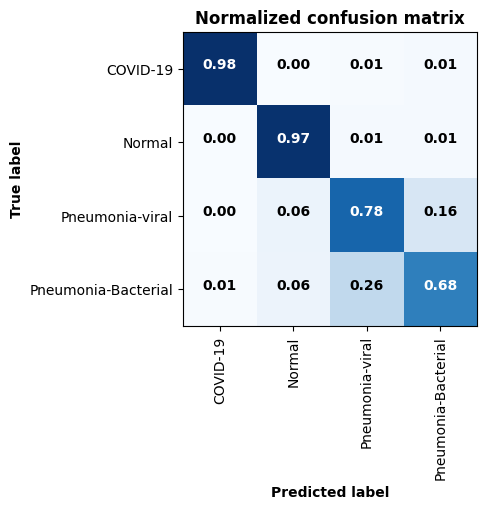

In [31]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix without normalization")
  
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title,weight='bold')
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=90)
  plt.yticks(tick_marks,classes)


  fmt='.2f' if normalize else 'd'
  thresh=cm.max()/2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',weight='bold',
             color='white' if cm[i,j]> thresh else 'black')
  plt.tight_layout()
  plt.ylabel("True label", weight='bold')
  plt.xlabel("Predicted label",weight="bold")

#compute confusion matrix
cnf_matrix=confusion_matrix(y_true_classes, y_pred_classes)
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['COVID-19','Normal','Pneumonia-viral','Pneumonia-Bacterial'],normalize=True,title="Normalized confusion matrix")
plt.show()